## Pulsars



The data is taken from HTRU2, a data set which describes a sample of pulsar candidates collected during the
High Time Resolution Universe Survey (South).

Author: Rob Lyon, School of Computer Science & Jodrell Bank Centre for Astrophysics,
                University of Manchester, Kilburn Building, Oxford Road, Manchester M13 9PL.

Contact:        rob@scienceguyrob.com or robert.lyon@.manchester.ac.uk
Web:            http://www.scienceguyrob.com or http://www.cs.manchester.ac.uk
                        or alternatively http://www.jb.man.ac.uk


The text below is copied from the Readme.txt file:

Pulsars are a rare type of Neutron star that produce radio emission detectable here on
Earth. They are of considerable scientific interest as probes of space-time, the inter-
stellar medium, and states of matter.
        
As pulsars rotate, their emission beam sweeps across the sky, and when this crosses
our line of sight, produces a detectable pattern of broadband radio emission. As pulsars
rotate rapidly, this pattern repeats periodically. Thus pulsar search involves looking
for periodic radio signals with large radio telescopes.
        
Each pulsar produces a slightly different emission pattern, which varies slightly with each
rotation (see [2] for an introduction to pulsar astrophysics to find out why). Thus a 
potential signal detection known as a 'candidate', is averaged over many rotations of the
pulsar, as determined by the length of an observation. In the absence of additional info,
each candidate could potentially describe a real pulsar. However in practice almost all
detections are caused by radio frequency interference (RFI) and noise, making legitimate
signals hard to find.
        
Machine learning tools are now being used to automatically label pulsar candidates to
facilitate rapid analysis. Classification systems in particular are being widely adopted,
(see [4,5,6,7,8,9]) which treat the candidate data sets  as binary classification problems.
Here the legitimate pulsar examples are a minority positive class, and spurious examples
the majority negative class. At present multi-class labels are unavailable, given the
costs associated with data annotation.
        
The data set shared here contains 16,259 spurious examples caused by RFI/noise, and 1,639
real pulsar examples. These examples have all been checked by human annotators. Each
candidate is described by 8 continuous variables. The first four are simple statistics
obtained from the integrated pulse profile (folded profile). This is an array of continuous
variables that describe a longitude-resolved version of the signal that has been averaged
in both time and frequency (see [3] for more details). The remaining four variables are
similarly obtained from the DM-SNR curve (again see [3] for more details). These are 
summarised below:
        
1. Mean of the integrated profile.
2. Standard deviation of the integrated profile.
3. Excess kurtosis of the integrated profile.
4. Skewness of the integrated profile.
5. Mean of the DM-SNR curve.
6. Standard deviation of the DM-SNR curve.
7. Excess kurtosis of the DM-SNR curve.
8. Skewness of the DM-SNR curve.

9. 0 : noise
   1 : pulsar
   
Demonstration:
1. SoftMaxModel
2. Multiple input and output
3. Bernoulli ErrorDistribution
4. NestedSampler

In [1]:
import numpy as numpy
import math

from astropy.io import ascii
from BayesicFitting import SoftMaxModel
from BayesicFitting import BernoulliErrorDistribution
from BayesicFitting import LaplacePrior
from BayesicFitting import CauchyPrior

from BayesicFitting import ClassicProblem
from BayesicFitting import MultipleOutputProblem
from BayesicFitting import NestedSampler
from BayesicFitting import formatter as fmt
from BayesicFitting import plotFit
from BayesicFitting import Tools
import matplotlib.pyplot as plt



In [2]:
#%matplotlib osx

In [3]:
tbl = ascii.read( "data/HTRU.csv" )


In [4]:
xall = numpy.zeros( (8,17898), dtype=float )
for k in range( 8 ) :
    key = 'col%d' % (k+1)
    xall[k,:] = tbl[key].data

y = tbl["col9"].data

print( fmt( xall, tail=3 ) )

#w = numpy.ones_like( y )
#wgt = numpy.where( y == 0, w, 10 * w )

[[  140.562  102.508  103.016  136.750   88.727 ...  119.336  114.508   57.062]
 [   55.684   58.882   39.342   57.178   40.672 ...   59.936   53.902   85.797]
 [   -0.235    0.465    0.323   -0.068    0.601 ...    0.159    0.201    1.406]
 [   -0.700   -0.515    1.051   -0.636    1.123 ...   -0.743   -0.025    0.090]
 [    3.200    1.677    3.121    3.643    1.179 ...   21.431    1.946  188.306]
 [   19.110   14.860   21.745   20.959   11.469 ...   58.872   13.382   64.713]
 [    7.976   10.576    7.736    6.896   14.270 ...    2.500   10.008   -1.598]
 [   74.242  127.394   63.172   53.594  252.567 ...    4.595  134.239    1.429]]


Rescale the data

In [5]:
xdata = xall.T
xm = numpy.mean( xdata, 0 )
print( fmt( xm, max=None ) )

xmm = [100, 10, 1, 1, 10, 10, 1, 10]
xdat = xdata / xmm
print( fmt( xdat, tail=3 ) )


[  111.080   46.550    0.478    1.770   12.614   26.327    8.304  104.858]
[[    1.406    5.568   -0.235   -0.700    0.320    1.911    7.976    7.424]
 [    1.025    5.888    0.465   -0.515    0.168    1.486   10.576   12.739]
 [    1.030    3.934    0.323    1.051    0.312    2.174    7.736    6.317]
 [    1.367    5.718   -0.068   -0.636    0.364    2.096    6.896    5.359]
 [    0.887    4.067    0.601    1.123    0.118    1.147   14.270   25.257]
  ...
 [    1.193    5.994    0.159   -0.743    2.143    5.887    2.500    0.460]
 [    1.145    5.390    0.201   -0.025    0.195    1.338   10.008   13.424]
 [    0.571    8.580    1.406    0.090   18.831    6.471   -1.598    0.143]]


Start a SoftMaxModel (logistic) with 8 inputs and 2 outputs

In [6]:
mdl = SoftMaxModel( ndim=8, ndout=2, offset=True )
mdl.setPrior( 0, CauchyPrior( ) )

#Tools.printclass( mdl )

problem = ClassicProblem( model=mdl, xdata=xdat, ydata=y )    #, weights=wgt )

Use NestedSampler with a BernoulliErrdorDistribution, for categorials.

Due to the wide range of the CauchyPrior, some sets of parameters produce overflow in the exp. Later in the algoritm more errors (infinties or NaNs) are made. However the process overcomes, i.e. neglects, these problems and yields a valid end result.

In [7]:
ns = NestedSampler( problem=problem, distribution="bernoulli", verbose=2 )

loge = ns.sample()

Fit all parameters of
  SoftMax: f_n( x:p ) = exp( sum_i( x_i * p_in ) + q_n)/ sum_n )
Using a Bernoulli error distribution
Moving the walkers with   GalileanEngine  ChordEngine
Iteration     logZ        H       LowL     npar parameters


/Users/do/PYTHON/Master/BayesicFitting/BayesicFitting/source/NeuralNetUtilities.py:287: RuntimeWarning: overflow encountered in exp
  res = numpy.exp( xdata )
/Users/do/PYTHON/Master/BayesicFitting/BayesicFitting/source/NeuralNetUtilities.py:289: RuntimeWarning: invalid value encountered in true_divide
  return ( res.T / sum ).T
/Users/do/PYTHON/Master/BayesicFitting/BayesicFitting/source/BernoulliErrorDistribution.py:156: RuntimeWarning: divide by zero encountered in log
  return numpy.log( lld )
/Users/do/PYTHON/Master/BayesicFitting/BayesicFitting/source/GalileanEngine.py:255: RuntimeWarning: invalid value encountered in double_scalars
  b = 4 * Lm - L1 - 3 * L0
/Users/do/PYTHON/Master/BayesicFitting/BayesicFitting/source/GalileanEngine.py:256: RuntimeWarning: invalid value encountered in double_scalars
  a = 2 * L0 - 4 * Lm  + 2 * L1
/Users/do/PYTHON/Master/BayesicFitting/BayesicFitting/source/GalileanEngine.py:264: RuntimeWarning: invalid value encountered in double_scalars
  x1 =

       0  -2.80e+06      4.6  -2.80e+06     18  [    0.529  -19.301    0.658   -0.096 ...]


/Users/do/PYTHON/Master/BayesicFitting/BayesicFitting/source/GalileanEngine.py:261: RuntimeWarning: invalid value encountered in double_scalars
  det = b * b - 4 * a * ( c - lowL )
/Users/do/PYTHON/Master/BayesicFitting/BayesicFitting/source/NeuralNetUtilities.py:303: RuntimeWarning: invalid value encountered in true_divide
  dfdx[k,:,n] = - ( f[:,k] * f[:,n] / n2 )
/Users/do/PYTHON/Master/BayesicFitting/BayesicFitting/source/NeuralNetUtilities.py:304: RuntimeWarning: invalid value encountered in true_divide
  dfdx[n,:,n] = ( ( norm - f[:,n]  ) * f[:,n] / n2 ).T
/Users/do/PYTHON/Master/BayesicFitting/BayesicFitting/source/NeuralNetUtilities.py:296: RuntimeWarning: overflow encountered in multiply
  n2 = norm * norm
/Users/do/PYTHON/Master/BayesicFitting/BayesicFitting/source/NeuralNetUtilities.py:303: RuntimeWarning: overflow encountered in multiply
  dfdx[k,:,n] = - ( f[:,k] * f[:,n] / n2 )


     100  -1.59e+05      5.6  -1.59e+05     18  [    2.718    1.169    1.863    2.162 ...]


/Users/do/PYTHON/Master/BayesicFitting/BayesicFitting/source/BernoulliErrorDistribution.py:223: RuntimeWarning: divide by zero encountered in true_divide
  dLdM[q,k] = 1.0 / mock[q,k]
/Users/do/PYTHON/Master/BayesicFitting/BayesicFitting/source/BernoulliErrorDistribution.py:223: RuntimeWarning: overflow encountered in true_divide
  dLdM[q,k] = 1.0 / mock[q,k]
/Users/do/PYTHON/Master/BayesicFitting/BayesicFitting/source/NeuralNetUtilities.py:292: RuntimeWarning: overflow encountered in exp
  f = numpy.exp( xdata )
/Users/do/PYTHON/Master/BayesicFitting/BayesicFitting/source/NeuralNetUtilities.py:304: RuntimeWarning: overflow encountered in multiply
  dfdx[n,:,n] = ( ( norm - f[:,n]  ) * f[:,n] / n2 ).T
/Users/do/PYTHON/Master/BayesicFitting/BayesicFitting/source/NeuralNetUtilities.py:304: RuntimeWarning: invalid value encountered in subtract
  dfdx[n,:,n] = ( ( norm - f[:,n]  ) * f[:,n] / n2 ).T


     200  -6.34e+04      6.6  -6.34e+04     18  [   -0.551   -0.066   -0.450    0.137 ...]
     300  -3.17e+04      7.6  -3.17e+04     18  [   -1.696   -0.068    0.151   -0.242 ...]
     400  -1.65e+04      8.6  -1.65e+04     18  [   -1.203    0.010   -0.607   -0.189 ...]
     500  -1.01e+04      9.6  -1.01e+04     18  [   -0.339    0.838   -0.792   -1.361 ...]
     600  -7.39e+03      9.9  -7.38e+03     18  [    1.442    2.603    3.543   -0.433 ...]
     700  -5.32e+03     11.6  -5.31e+03     18  [   -2.211   -0.323   -1.348   -1.139 ...]
     800  -4.14e+03     12.5  -4.13e+03     18  [   -0.586    0.078  -22.753    0.575 ...]
     900  -3.46e+03     13.5  -3.44e+03     18  [   -1.148   -0.033   -1.406   -0.210 ...]
    1000  -2.92e+03     14.6  -2.90e+03     18  [    0.702   -0.663    0.594   -0.628 ...]
    1100  -2.53e+03     14.7  -2.52e+03     18  [   -1.532    0.621   -1.132    0.174 ...]
    1200  -2.23e+03     15.8  -2.21e+03     18  [   -1.930    0.313  -10.033    0.937 ...]

In [8]:
sl = ns.samples
pars = sl[-1].parameters
yfit = mdl.result( xdat, pars )
print( yfit.shape )
yfit = yfit[:,1]

(17898, 2)


As there are only 2 outputs yfit1 is the reverse of yfit2 (= 1 - yfit1 )

[12186 14049 13504 ...  4422   537  9937]


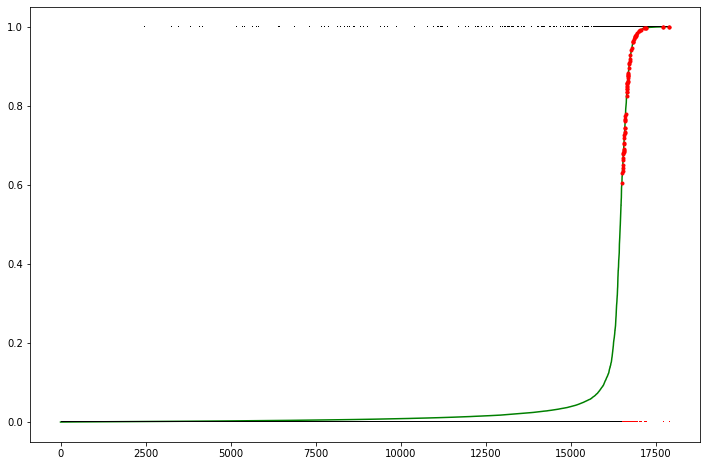

In [9]:

#yfit = ns.yfit
kst = numpy.argsort( yfit )
yf = yfit[kst]
yy = y[kst]

print( kst )
q = numpy.where( ( yy == 0 ) & ( yf > 0.6 ) )

xx = numpy.arange( len( y ) )
plt.figure( 1, figsize=[12,8] )
col = ['k.','r.','g.','b.','c.','m.','y.'] 
plt.plot( xx, yf, 'g-' )
plt.plot( xx, yy, 'k,')
plt.plot( q[0], yy[q], 'r,' )
plt.plot( q[0], yf[q], 'r.' )
plt.show()


The separation between pulsars and noise is not perfect, based on the data at hand.

One might surmise that the red dots might be pulsars too, in stead of noise. 